In [1]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers

2023-12-16 15:43:44.167740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Model Data 
Checkpoint: Load cached data here

In [2]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [3]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [4]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df

In [5]:
# PLOT MODEL PROGRESS
def plot_history(history, history_continued, tl_epoch): 
    # Get training history
    training_loss = history.history['loss'] + history_continued.history['loss']
    training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
    val_loss = history.history['val_loss'] + history_continued.history['val_loss']
    val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
    epochs = range(1, len(training_loss) + 1)

    # Plotting loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.axvline(x = tl_epoch, color = 'gray', label = 'transferred', linestyle='dotted')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1) 
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axvline(x = tl_epoch, color = 'gray', label = 'transferred', linestyle='dotted')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Define Model and Prepare Data

In [6]:
# Prepare Model Data --> [takes 2 min.]
pca = PCA(n_components=25) 
prognosis_names = encoded_df.label.unique()

def get_x_y(df): 
    x = np.array([pca.fit_transform(np.transpose(data)) for data in df.sample_data.values]) # shrink to 26 values
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df)) # training data

x_train_black, y_train_black = get_x_y(train_black_df)
x_train_asian, y_train_asian = get_x_y(train_asian_df)

x_test_white, y_test_white = get_x_y(test_white_df)
x_test_black, y_test_black = get_x_y(test_black_df)
x_test_asian, y_test_asian = get_x_y(test_asian_df)

In [7]:
# DEFINE MODEL

# Assuming your input data is stored in a variable named 'x_input'
# x_input.shape should be (602, 26, 25)
x_input = x_train

# Assuming your one-hot encoded labels are stored in a variable named 'y_output'
# y_output.shape should be (602, 23)
y_output = y_train

# Define the Transformer model using Keras
def build_transformer_model(input_shape, num_classes, num_blocks):
    inputs = Input(shape=input_shape)
    x = inputs

    # Transformer Encoder Block 
    for i in range(0, num_blocks):
        # Self Attention
        x_t = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=25)(x, x)
        x_t = Dropout(0.1)(x_t)
        x = LayerNormalization(axis=-1)(x_t + x)
        
        # FC Layer
        x_t = Dense(128, activation='relu')(x)
        x_t = Dropout(0.1)(x_t)
        x_t = Dense(25, activation='relu')(x_t)
        x_t = Dropout(0.1)(x_t)
        x = LayerNormalization(axis=-1)(x_t + x)

    # Decoder 
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Freeze Model Function 
def freeze_model(model): 
    model.trainable = False 
    for layer in model.layers[-2:]: 
        layer.trainable = True 

    return model 


# Instantiate the model
input_shape = (26, 25)
num_classes = 23  # Assuming 23 classes
transformer_model = build_transformer_model(input_shape, num_classes, num_blocks=3)


### Model Results for Freezing Last 2 Layers

In [8]:
### RESULTS FOR BLACK / AA Patients 

# Compile the model
transformer_model.trainable = True
transformer_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss=CategoricalCrossentropy(),
                          metrics=['accuracy'])


# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = transformer_model.fit(x_input, y_output, epochs=8, batch_size=32, validation_split=0.2)

# Freeze model 
transformer_model = freeze_model(transformer_model)

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = transformer_model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
16/16 [==============================] - 8s 82ms/step - loss: 1.7321 - accuracy: 0.6008 - val_loss: 1.3854 - val_accuracy: 0.6860
Epoch 2/8
16/16 [==============================] - 1s 32ms/step - loss: 1.2383 - accuracy: 0.6549 - val_loss: 1.2820 - val_accuracy: 0.6860
Epoch 3/8
16/16 [==============================] - 1s 39ms/step - loss: 1.1787 - accuracy: 0.6549 - val_loss: 1.2297 - val_accuracy: 0.6860
Epoch 4/8
16/16 [==============================] - 1s 37ms/step - loss: 1.1399 - accuracy: 0.6549 - val_loss: 1.2174 - val_accuracy: 0.6860
Epoch 5/8
16/16 [==============================] - 1s 32ms/step - loss: 1.1148 - accuracy: 0.6549 - val_loss: 1.2037 - val_accuracy: 0.6860
Epoch 6/8
16/16 [==============================] - 1s 32ms/step - loss: 1.1092 - accuracy: 0.6549 - val_loss: 1.2101 - val_accuracy: 0.6860
Epoch 7/8
16/16 [==============================] - 1s 32ms/step - loss: 1.1057 - accuracy: 0.6

In [9]:
# Check Test Performance - Black & AA Patients
evaluation = transformer_model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 11ms/step - loss: 1.0593 - accuracy: 0.8205
Performance on Black Patients
----------------------------------
Loss on test data: 1.0593136548995972
Accuracy on test data: 0.8205128312110901


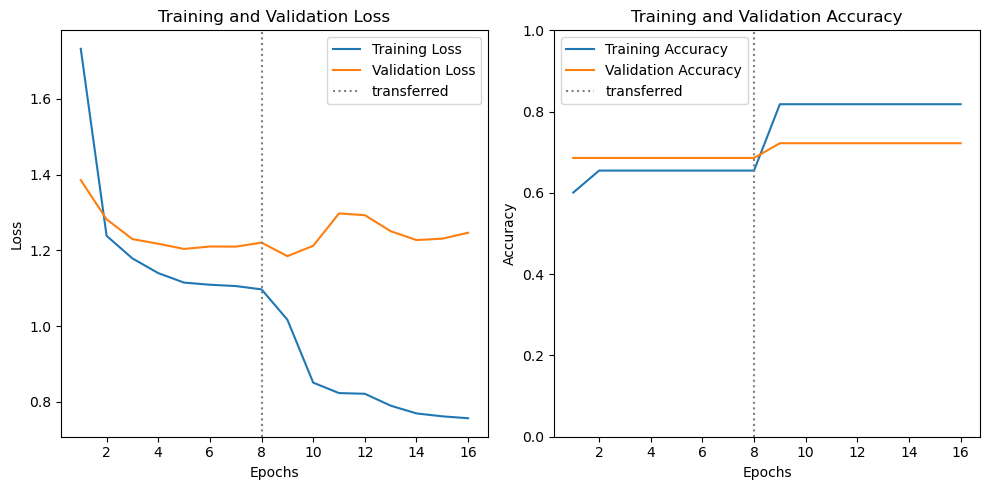

In [10]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

In [11]:
### RESULTS FOR Asian Patients 

# Compile the model
transformer_model.trainable = True
transformer_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss=CategoricalCrossentropy(),
                          metrics=['accuracy'])


# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = transformer_model.fit(x_input, y_output, epochs=8, batch_size=32, validation_split=0.2)

# Freeze model 
transformer_model = freeze_model(transformer_model)

# Transfer Learning 
print("---------------------- TRANSFER TO ASIAN DATA ----------------------")
history_continued = transformer_model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
16/16 [==============================] - 7s 81ms/step - loss: 1.1691 - accuracy: 0.6549 - val_loss: 1.2340 - val_accuracy: 0.6860
Epoch 2/8
16/16 [==============================] - 0s 31ms/step - loss: 1.1027 - accuracy: 0.6549 - val_loss: 1.2002 - val_accuracy: 0.6860
Epoch 3/8
16/16 [==============================] - 0s 31ms/step - loss: 1.0984 - accuracy: 0.6549 - val_loss: 1.1967 - val_accuracy: 0.6860
Epoch 4/8
16/16 [==============================] - 0s 31ms/step - loss: 1.0879 - accuracy: 0.6549 - val_loss: 1.2089 - val_accuracy: 0.6860
Epoch 5/8
16/16 [==============================] - 0s 31ms/step - loss: 1.1070 - accuracy: 0.6549 - val_loss: 1.2027 - val_accuracy: 0.6860
Epoch 6/8
16/16 [==============================] - 0s 31ms/step - loss: 1.0809 - accuracy: 0.6549 - val_loss: 1.2054 - val_accuracy: 0.6860
Epoch 7/8
16/16 [==============================] - 1s 32ms/step - loss: 1.0831 - accuracy: 0.6

In [12]:
# Check Test Performance - Asian Patients
evaluation = transformer_model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 51ms/step - loss: 0.8074 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 0.8074449300765991
Accuracy on test data: 0.8214285969734192


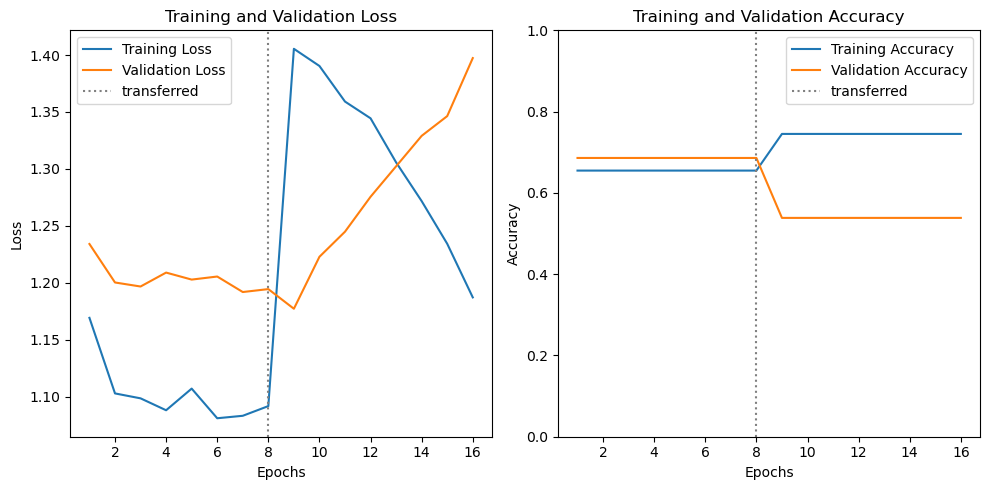

In [13]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

### Model Results for just Fine Tuning

In [14]:
### RESULTS FOR BLACK / AA Patients 

# Compile the model
transformer_model.trainable = True
transformer_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss=CategoricalCrossentropy(),
                          metrics=['accuracy'])


# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = transformer_model.fit(x_input, y_output, epochs=8, batch_size=32, validation_split=0.2)

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = transformer_model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
16/16 [==============================] - 7s 95ms/step - loss: 1.1401 - accuracy: 0.6549 - val_loss: 1.2131 - val_accuracy: 0.6860
Epoch 2/8
16/16 [==============================] - 1s 39ms/step - loss: 1.0823 - accuracy: 0.6549 - val_loss: 1.2055 - val_accuracy: 0.6860
Epoch 3/8
16/16 [==============================] - 1s 34ms/step - loss: 1.0818 - accuracy: 0.6570 - val_loss: 1.1910 - val_accuracy: 0.6860
Epoch 4/8
16/16 [==============================] - 1s 39ms/step - loss: 1.0723 - accuracy: 0.6549 - val_loss: 1.1867 - val_accuracy: 0.6860
Epoch 5/8
16/16 [==============================] - 1s 41ms/step - loss: 1.0621 - accuracy: 0.6549 - val_loss: 1.1662 - val_accuracy: 0.6860
Epoch 6/8
16/16 [==============================] - 1s 39ms/step - loss: 1.0786 - accuracy: 0.6549 - val_loss: 1.1708 - val_accuracy: 0.6860
Epoch 7/8
16/16 [==============================] - 1s 31ms/step - loss: 1.0679 - accuracy: 0.6

In [15]:
# Check Test Performance - Black & AA Patients
evaluation = transformer_model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 11ms/step - loss: 1.0374 - accuracy: 0.8205
Performance on Black Patients
----------------------------------
Loss on test data: 1.037415623664856
Accuracy on test data: 0.8205128312110901


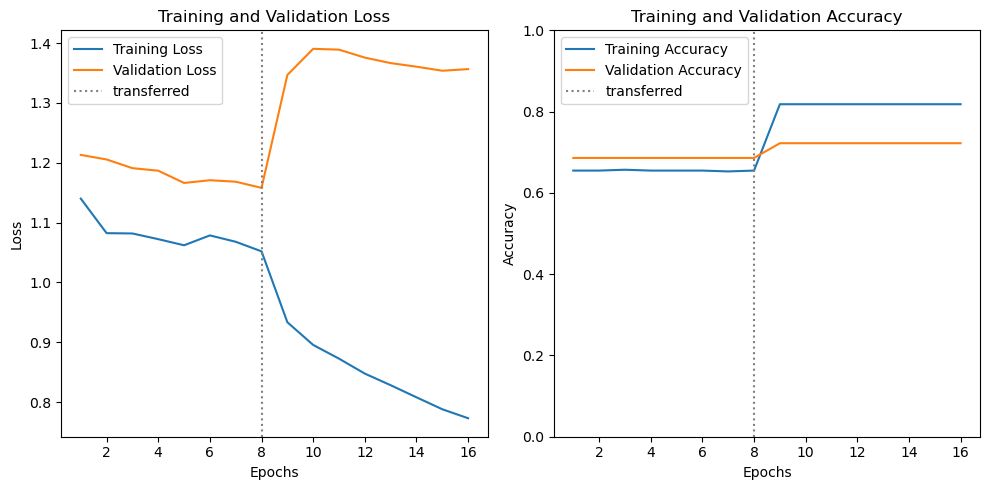

In [16]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

In [17]:
### RESULTS FOR Asian Patients 

# Compile the model
transformer_model.trainable = True
transformer_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss=CategoricalCrossentropy(),
                          metrics=['accuracy'])


# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = transformer_model.fit(x_input, y_output, epochs=8, batch_size=32, validation_split=0.2)

# Transfer Learning 
print("---------------------- TRANSFER TO ASIAN DATA ----------------------")
history_continued = transformer_model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
16/16 [==============================] - 8s 80ms/step - loss: 1.1035 - accuracy: 0.6549 - val_loss: 1.1825 - val_accuracy: 0.6860
Epoch 2/8
16/16 [==============================] - 1s 32ms/step - loss: 1.0562 - accuracy: 0.6528 - val_loss: 1.1799 - val_accuracy: 0.6860
Epoch 3/8
16/16 [==============================] - 1s 32ms/step - loss: 1.0713 - accuracy: 0.6549 - val_loss: 1.1960 - val_accuracy: 0.6694
Epoch 4/8
16/16 [==============================] - 1s 33ms/step - loss: 1.0478 - accuracy: 0.6528 - val_loss: 1.1728 - val_accuracy: 0.6860
Epoch 5/8
16/16 [==============================] - 1s 43ms/step - loss: 1.0450 - accuracy: 0.6528 - val_loss: 1.1657 - val_accuracy: 0.6777
Epoch 6/8
16/16 [==============================] - 1s 33ms/step - loss: 1.0359 - accuracy: 0.6570 - val_loss: 1.1909 - val_accuracy: 0.6860
Epoch 7/8
16/16 [==============================] - 1s 31ms/step - loss: 1.0209 - accuracy: 0.6

In [18]:
# Check Test Performance - Asian Patients
evaluation = transformer_model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 110ms/step - loss: 0.6168 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 0.6167675852775574
Accuracy on test data: 0.8214285969734192


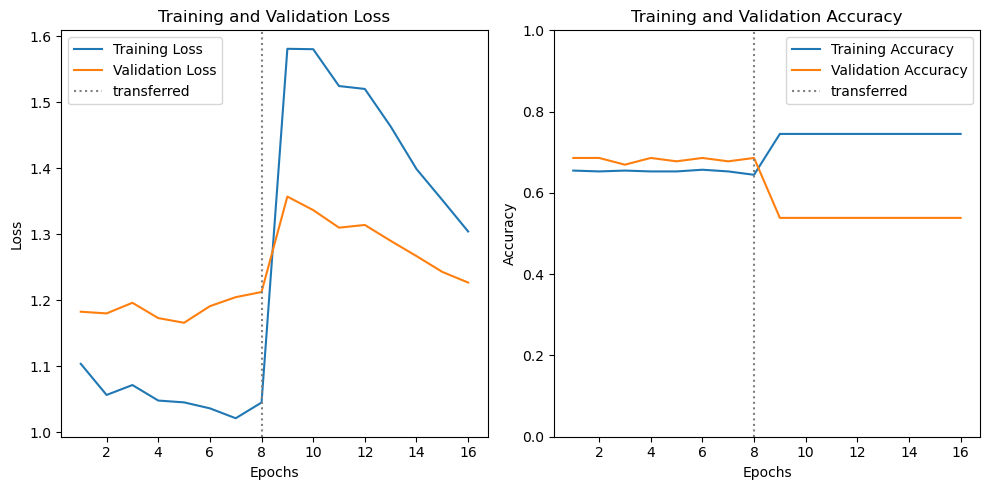

In [19]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)